In [2]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sysName = "P2"

## Material parameters and other general definitions

In [ ]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha = 0               # editalo
alpha_Low_YIG = 1e-4    # Gilbert damping (-)
alpha_High_YIG = 1e12   # Gilbert damping (-)

Ms_YIG = 1e5            # Saturation magnetisation (A/m)

A_YIG = 4e-12           # Exchange stiffness (J/m)

## Sample and mesh cell creation

In [ ]:
# Geometry [nm]
t = 50e-9
w = 500e-9
l = 5000e-9

# Mesh cell [nm]
cx = 12.5e-9
cy = 12.5e-9
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx = 50*Oe
Hy = 10*Oe
Hz = 0

H_DC = (Hx, Hy, Hz)  # Zeeman field
# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

## Energy and boundary conditions definition

In [ ]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driver

# self absorbing boundary condition
band = 0.25e-6

In [4]:


# system definition
system = mm.System(name=sysName)
region = df.Region(p1=(-l, -w, 0), p2=(l, w, t))
mesh = df.Mesh(region=region, cell=cell)


def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_Low_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_Low_YIG)

    else:
        return (alpha_Low_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)

In [5]:

### SYSTEM INITIALIZATION ###
# set a magnetization different
def Ms_value(pos):
    # from 0 only inside the sample
    x, y, z = pos

    if (l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

In [6]:
# get system to equilibrium
system.energy = dem + ex+zem
mn.drive(system)

damping = mm.Damping(alpha=alpha)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/01/09 18:55]... (0.4 s)


In [7]:
# inject RF field and time sim
T = 10e-9
f_MAX = 3e9

f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling


def Hspace_RF(point):
    x, y, z = point
    if (-l/2+band/2 < x < -l/2+band and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, 10*Oe)
    else:
        return (0, 0, 0)


H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func='sinc', f=f_MAX, t0=T/sampling, name='RF')
system.energy = dem + ex+zem
system.energy += zemRF
td.drive(system, t=T, n=sampling, n_thread=19)

Running OOMMF (ExeOOMMFRunner)[2024/01/09 18:55]... (3.6 s)


In [8]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data = np.array(array)

""" prende l'ultimo drive, su tutti i sample (:), su tutti i valori di x dove l'assorbimento
    è basso (lontano dai bordi), su un fissato t e un fissato z.
    L'ultima cifra nella [] indica la componente x, y o z di m
    dovrebbero essere numsample*numMesh lungo x
"""

mx = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 0]
my = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 1]
mz = data[:, round((l/2+band)/cx):round((3/2*l-band)/cx), round(w/cy), 0, 2]

In [9]:


# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

/tmp/ipykernel_1900/1739682690.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(m_fft_x)**2), extent=extent,
/tmp/ipykernel_1900/1739682690.py:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(m_fft_y)**2), extent=extent,
/tmp/ipykernel_1900/1739682690.py:26: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(m_fft_z)**2), extent=extent,


Text(0.5, 0, '$kz$ (1/m)')

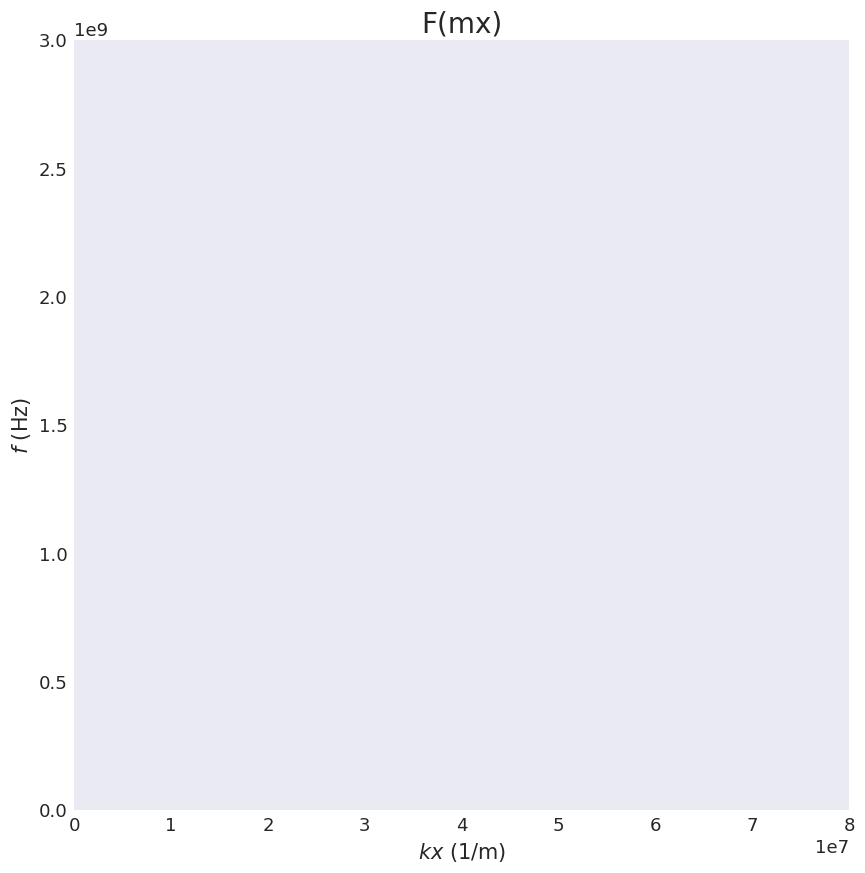

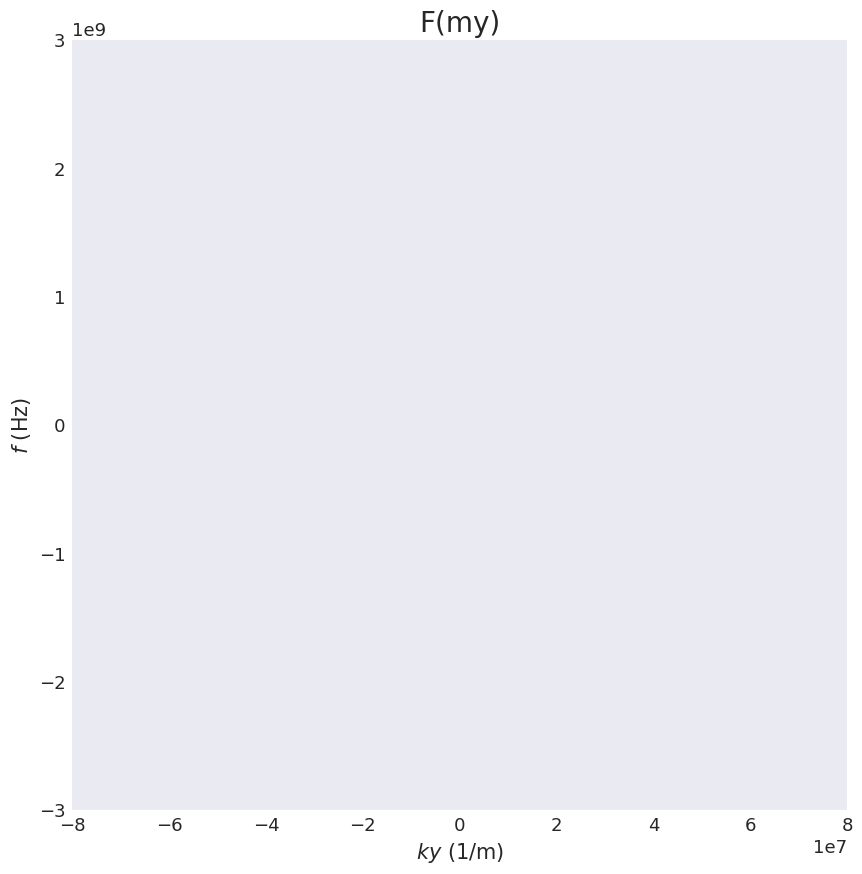

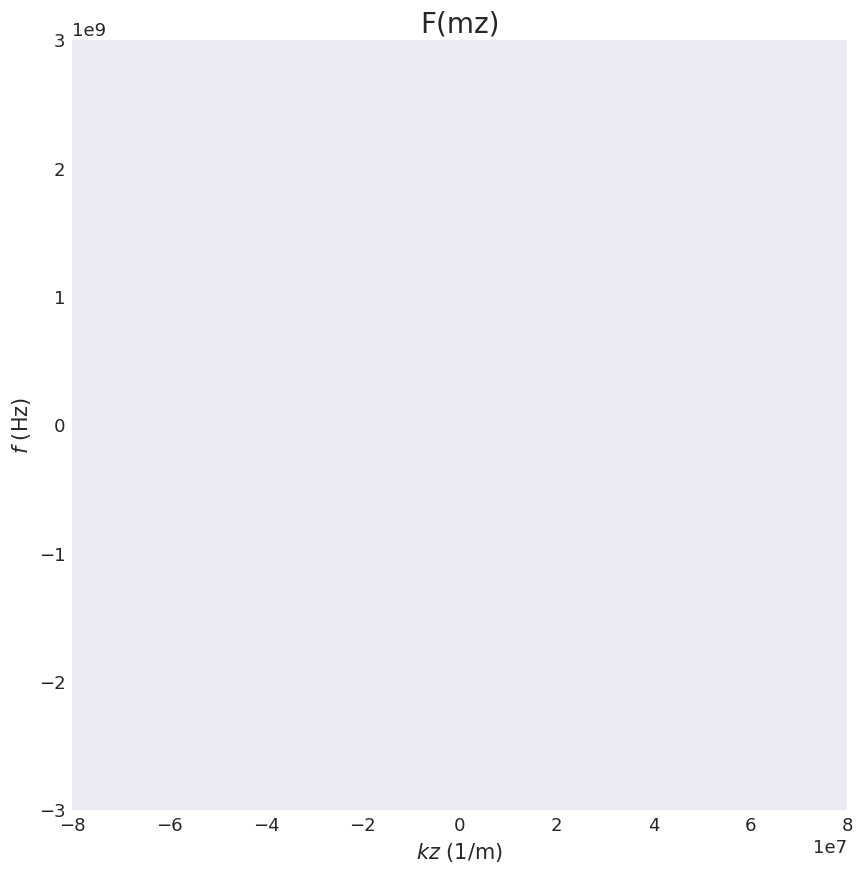

In [10]:
# Show the intensity plot of the 2D FFT
plt.figure(figsize=(10, 10))
plt.title('F(mx)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_x)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kx$ (1/m)")

plt.xlim([0, 1/cx])
plt.ylim([0, f_MAX])

plt.figure(figsize=(10, 10))
plt.title('F(my)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_y)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")

plt.ylabel("$f$ (Hz)")
plt.xlabel("$ky$ (1/m)")


plt.figure(figsize=(10, 10))
plt.title('F(mz)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_z)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kz$ (1/m)")